In [1]:
!rm -rf /kaggle/working/*

In [2]:
!pip install moviepy
!pip install autokeras
!pip install --upgrade keras_nlp
# Fix for the plotting in Kaggle 
!pip install pydot
!apt-get install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 122 not upgraded.


In [3]:
import tensorflow as tf
import os
import glob
import cv2
import shutil
import torchaudio
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
import autokeras as ak
from tensorflow.keras.models import save_model
from moviepy.video.io.VideoFileClip import VideoFileClip
import librosa
from sklearn.model_selection import train_test_split
import h5py

2025-04-21 05:21:50.827217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745212910.853122   66468 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745212910.860519   66468 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Setting up paths
base_path = "/kaggle/input"
src_dir_real = "/kaggle/input/Celeb-real"
src_dir_fake = "/kaggle/input/Celeb-synthesis"
src_dir_yt = "/kaggle/input/YouTube-real"
dest_dir_real = "/kaggle/working/dataset/real"
dest_dir_fake = "/kaggle/working/dataset/fake"
dest_dataset_root = "/kaggle/working/dataset"

In [5]:
os.listdir(base_path)

['YouTube-real', 'Celeb-synthesis', 'Celeb-real', 'List_of_testing_videos.txt']

In [6]:
# Creating destination directories - if ignored, throws error while saving files
os.makedirs(dest_dir_real, exist_ok=True)
os.makedirs(dest_dir_fake, exist_ok=True)

In [7]:
list_real = os.listdir(src_dir_real)
print(len(list_real))
list_fake = os.listdir(src_dir_fake)
print(len(list_fake))
list_yt = os.listdir(src_dir_yt)
print(len(list_yt))

590
5639
300


In [8]:
# List of real videos in dataset

# Copying real files path to from source to destination
for filename in list_real:
    src_file = os.path.join(src_dir_real, filename)
    dest_file = os.path.join(dest_dir_real, filename)
    shutil.copy(src_file, dest_file)

for filename in list_yt:
    src_file = os.path.join(src_dir_yt, filename)
    dest_file = os.path.join(dest_dir_real, filename)
    shutil.copy(src_file, dest_file)

# Copying fake files path to from source to destination
for filename in list_fake[:(len(list_real) + len(list_yt))]:
    src_file = os.path.join(src_dir_fake, filename)
    dest_file = os.path.join(dest_dir_fake, filename)
    shutil.copy(src_file, dest_file)

print("Files copied successfully!")
print(len(os.listdir(dest_dir_real)), len(os.listdir(dest_dir_fake)))

Files copied successfully!
890 890


Why extract audio?

Deepfake videos often exhibit inconsistencies not just in visual cues but also in audio. By analyzing the audio component, the model can detect anomalies such as unnatural speech patterns, mismatches between lip movements and speech, or synthetic voice artifacts. Incorporating audio analysis enhances the model's ability to detect deepfakes more accurately

In [9]:
def extract_audio_files():
    real_video_files = glob.glob(os.path.join("/kaggle/working", dataset_root, "real", "*.mp4"))
    fake_video_files = glob.glob(os.path.join("/kaggle/working", dataset_root, "fake", "*.mp4"))
    all_video_files = real_video_files + fake_video_files
    for video_file in all_video_files:

        # Load the video file using moviepy to access its frames, duration, and audio
        # This will be used for extracting audio or performing video edits
        video_clip = VideoFileClip(video_file)

        # Load the video file and extract its audio component for further processing
        audio_clip = video_clip.audio
        output_audio_path = os.path.splitext(video_file)[0] + ".wav"
        audio_clip.write_audiofile(output_audio_path, codec+'pcm_s16le')

**Loading and Extracting Video frames**

In [10]:
def extract_video_frames(video_path, image_size, num_frames = 10):
    # Loading video file
    video_capture = cv2.VideoCapture(video_path)
    # Get the total number of frames in the video
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # print(f"Frame Count : {frame_count}")
    
    frames = []

    # Loop through the video and extract up to 'num_frames' frames
    for frame_num in range(min(frame_count, num_frames)):
        ret, frame = video_capture.read()  # Read the next frame
        if not ret:   # If frame not read successfully, exit loop
            break

        # Converting frames from BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resizing images to parameter image_size
        frame = cv2.resize(frame, image_size)
        frames.append(frame)
    # Returning processed frames
    return frames

In [11]:
dataset_root = "/kaggle/working/dataset"

real_video_paths = glob.glob(os.path.join(dataset_root, "real", "*.mp4"))
fake_video_paths = glob.glob(os.path.join(dataset_root, "fake", "*.mp4"))

# Frame image size
image_size = (64, 64)
num_samples = 100

print(len(real_video_paths), len(fake_video_paths))

# Extracting images(X = features) from video clips
#X_images_real = [extract_video_frames(video_p0ath, image_size) for video_path in real_video_paths]
#X_images_fake = [extract_video_frames(video_path, image_size) for video_path in fake_video_paths]
def extract_video_frames_safe(video_path, image_size, num_frames=10):
    frames = extract_video_frames(video_path, image_size, num_frames)
    return frames if len(frames) == num_frames else None

X_images = []
Y_labels = []

for video_path in real_video_paths:
    frames = extract_video_frames_safe(video_path, image_size)
    if frames is not None:
        X_images.append(frames)
        Y_labels.append(0)  # Real → 0

for video_path in fake_video_paths:
    frames = extract_video_frames_safe(video_path, image_size)
    if frames is not None:
        X_images.append(frames)
        Y_labels.append(1)  # Fake → 1

X_images = np.array(X_images)
Y_labels = np.array(Y_labels)

890 890


In [12]:
print("Valid videos:", len(X_images))
print("Valid labels:", len(Y_labels))

Valid videos: 1779
Valid labels: 1779


In [13]:
print(X_images.shape, Y_labels.shape)

(1779, 10, 64, 64, 3) (1779,)


In [14]:
# Using random seed as 42
X_images_train, X_images_test, Y_labels_train, Y_labels_test = train_test_split(
    X_images, Y_labels, test_size = 0.2, random_state = 42, shuffle=True
)

In [15]:
print("X_images_train shape:", X_images_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("Y_train shape:", Y_labels_train.shape)
print("Y_test shape:", Y_labels_test.shape)

X_images_train shape: (1423, 10, 64, 64, 3)
X_images_test shape: (356, 10, 64, 64, 3)
Y_train shape: (1423,)
Y_test shape: (356,)


In [16]:
# Save the data in a HDF5 file
h5_path = '/kaggle/working/dataset/data.h5'

if os.path.exists(h5_path):
    os.remove(h5_path)
    print("Deleted data.h5")
else:
    print("data.h5 not found")

# Save the data in a HDF5 file for faster processing and beter RAM utilization
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'w')

h5_file.create_dataset('X_images_train', data=X_images_train)
h5_file.create_dataset('X_images_test', data=X_images_test)
h5_file.create_dataset('y_labels_train', data=Y_labels_train)
h5_file.create_dataset('y_labels_test', data=Y_labels_test)

# Close the HDF5 file
h5_file.close()
print("Successfully loaded data into file!")

data.h5 not found
Successfully loaded data into file!


In [17]:
# Flush out the heavily loaded variables from memory
#del X_images_train
#del X_images_test
#del Y_labels_train
#del Y_labels_test

In [18]:
import gc
gc.collect()

30

I0000 00:00:1745212953.391055   66468 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12288)               │       1,585,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,594,176 (6.08 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64, 64, 1)           │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,833 (34.50 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 64, 64, 3)           │       1,594,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 64, 64, 1)           │           8,833 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,603,009 (6.11 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 8,833 (34.50 KB)

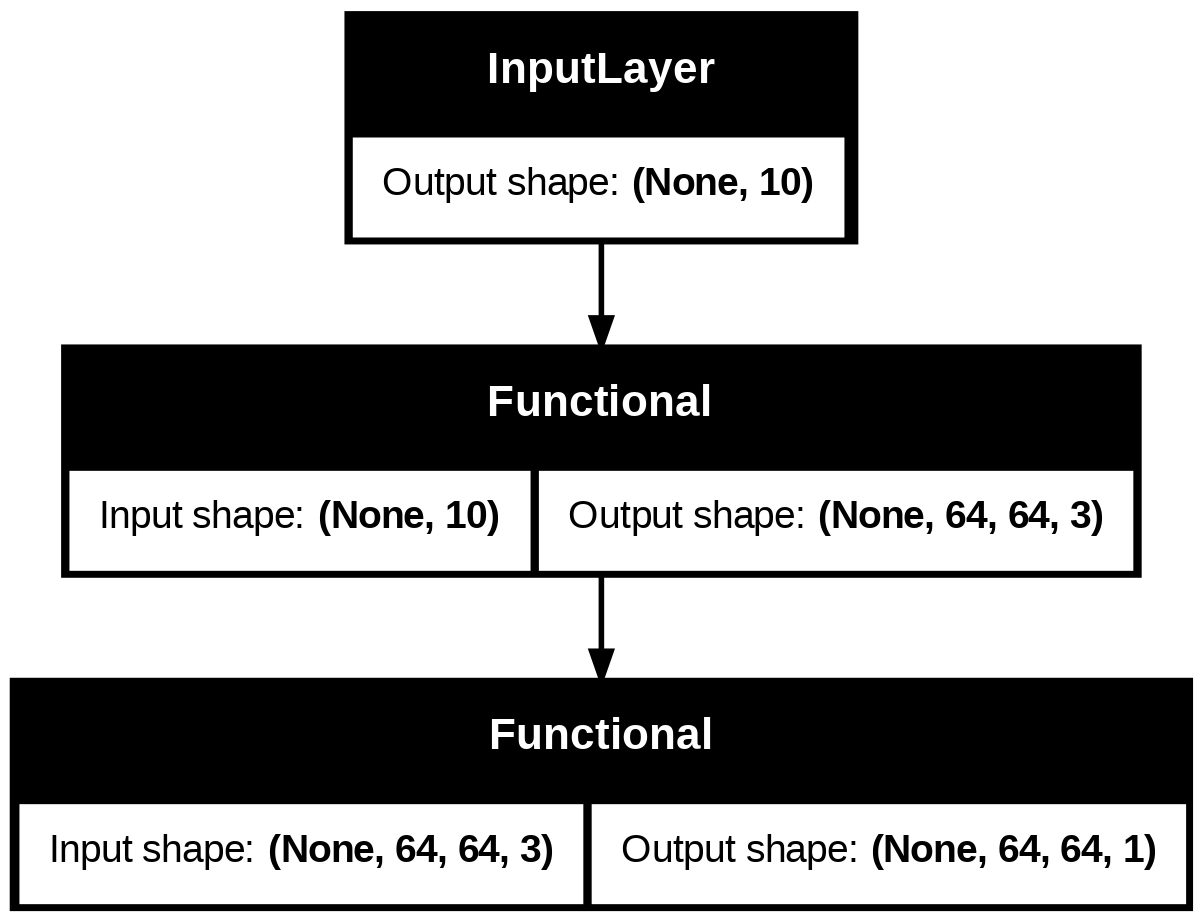

In [19]:
latent_dim = 10
image_shape = (64, 64, 3)
output_shape = (64, 64, 3)

# Build the Generator model
def build_generator(latent_dim, output_shape):
    generator_input = Input(shape=(latent_dim,))
    x = Dense(64)(generator_input)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)

    # Calculate the number of units in the Dense layer for the generator output
    num_units = output_shape[0] * output_shape[1] * output_shape[2]

    # Generator output with a Dense layer and reshape
    generated_data = Dense(num_units, activation='tanh')(x)
    generated_data = Reshape(output_shape)(generated_data)

    generator = Model(generator_input, generated_data)
    return generator

# Build the Discriminator model
def build_discriminator(input_shape):
    discriminator_input = Input(shape=input_shape)
    x = Dense(128)(discriminator_input)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    validity = Dense(1, activation='sigmoid')(x)
    discriminator = Model(discriminator_input, validity)
    return discriminator

# Build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)
    gan = Model(gan_input, gan_output)
    return gan

generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

# Print the model summaries
generator.summary()
discriminator.summary()
gan.summary()

# Plot the model architectures
plot_model(generator, show_shapes=True, to_file="generator.png")
plot_model(discriminator, show_shapes=True, to_file="discriminator.png")
plot_model(gan, show_shapes=True, to_file="gan.png")

In [20]:
def multimodal_fusion(images, num_modalities):
    num_samples, num_frames, height, width, channels = images.shape

    # Create additional modalities by converting images to grayscale
    additional_modalities = []
    for i in range(1, num_modalities):
        modified_images = []
        for frame in range(num_frames):
            grayscale_frame = np.mean(images[:, frame], axis=-1, keepdims=True)
            modified_images.append(grayscale_frame)
        additional_modalities.append(np.array(modified_images))

    # Tile the additional modalities to match the number of frames
    tiled_modalities = [modalities[:, np.newaxis] for modalities in additional_modalities]
    tiled_modalities = [np.tile(modalities, (1, num_frames, 1, 1, 1)) for modalities in tiled_modalities]

    # Concatenate the original images and additional modalities along the channel axis
    fused_data = np.concatenate((images, *tiled_modalities), axis=-1)
    return fused_data

In [21]:
import h5py
batch_size = 40
num_modalities = 1 #Add GrayScale with RGB modality

# Load the data from the HDF5 file
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'r')
num_samples = len(h5_file['X_images_train'])
y_train = h5_file['y_labels_train'][:]

multimodal_data = []

for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    batch_X_images_train = h5_file['X_images_train'][batch_start:batch_end]
    batch_X_images_test = h5_file['X_images_test'][batch_start:batch_end]

    # Perform multimodal fusion on the current batch
    fused_batch_X_train = multimodal_fusion(batch_X_images_train, num_modalities)
    fused_batch_X_test = multimodal_fusion(batch_X_images_test, num_modalities)
    multimodal_data.append(fused_batch_X_train)
    print("Fused batch X_train shape:", fused_batch_X_train.shape)
    print("Fused batch X_test shape:", fused_batch_X_test.shape)

h5_file.close()

Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (36, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape: (0, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_test shape

In [22]:
import autokeras as ak
from sklearn.model_selection import train_test_split
# Stack the multimodal data
fused_X_train = np.vstack(multimodal_data)

# Get the dimensions from the shape of fused_X_train
num_samples, num_frames, height, width, channels = fused_X_train.shape

# Reshape the data to match AutoKeras expected format
reshaped_X_train = fused_X_train.reshape((-1, height, width, channels))

# Reshape again to treat each frame as a separate sample
reshaped_X_train = reshaped_X_train.reshape((-1, height, width, channels))

# Reshape y_train to match the new number of samples
reshaped_Y_train = np.repeat(y_train, num_frames, axis=0)

print("reshaped_X_train shape:", reshaped_X_train.shape)
print("reshaped_y_train shape:", reshaped_Y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(reshaped_X_train, reshaped_Y_train, test_size=0.2, shuffle=True, random_state=42)


reshaped_X_train shape: (14230, 64, 64, 3)
reshaped_y_train shape: (14230,)


In [23]:
from sklearn.utils import class_weight
import numpy as np

# weight sampling for imbalanced classes
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(reshaped_Y_train),
    y=reshaped_Y_train
)

# Convert to dictionary for Keras
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.9923291492329149, 1: 1.0077903682719547}


In [24]:
# Create the image-based AutoKeras model
search = ak.ImageClassifier(max_trials=2)

# Train the NAS model
history = search.fit(
    reshaped_X_train, 
    reshaped_Y_train, 
    epochs=4, 
    validation_data=(X_val, y_val),
    class_weight = class_weights)
print(history.history.keys())

# Export the best model architecture
best_model = search.export_model()

Trial 2 Complete [00h 10m 54s]
val_loss: 0.711584746837616

Best val_loss So Far: 0.581683337688446
Total elapsed time: 00h 11m 14s
Epoch 1/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5039 - loss: 0.7445 - val_accuracy: 0.6448 - val_loss: 0.6645
Epoch 2/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5599 - loss: 0.6989 - val_accuracy: 0.5383 - val_loss: 0.7429
Epoch 3/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6267 - loss: 0.6634 - val_accuracy: 0.7108 - val_loss: 0.6134
Epoch 4/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6827 - loss: 0.5898 - val_accuracy: 0.7066 - val_loss: 0.5711
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          57,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Activation)   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,000 (300.79 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 7 (32.00 B)

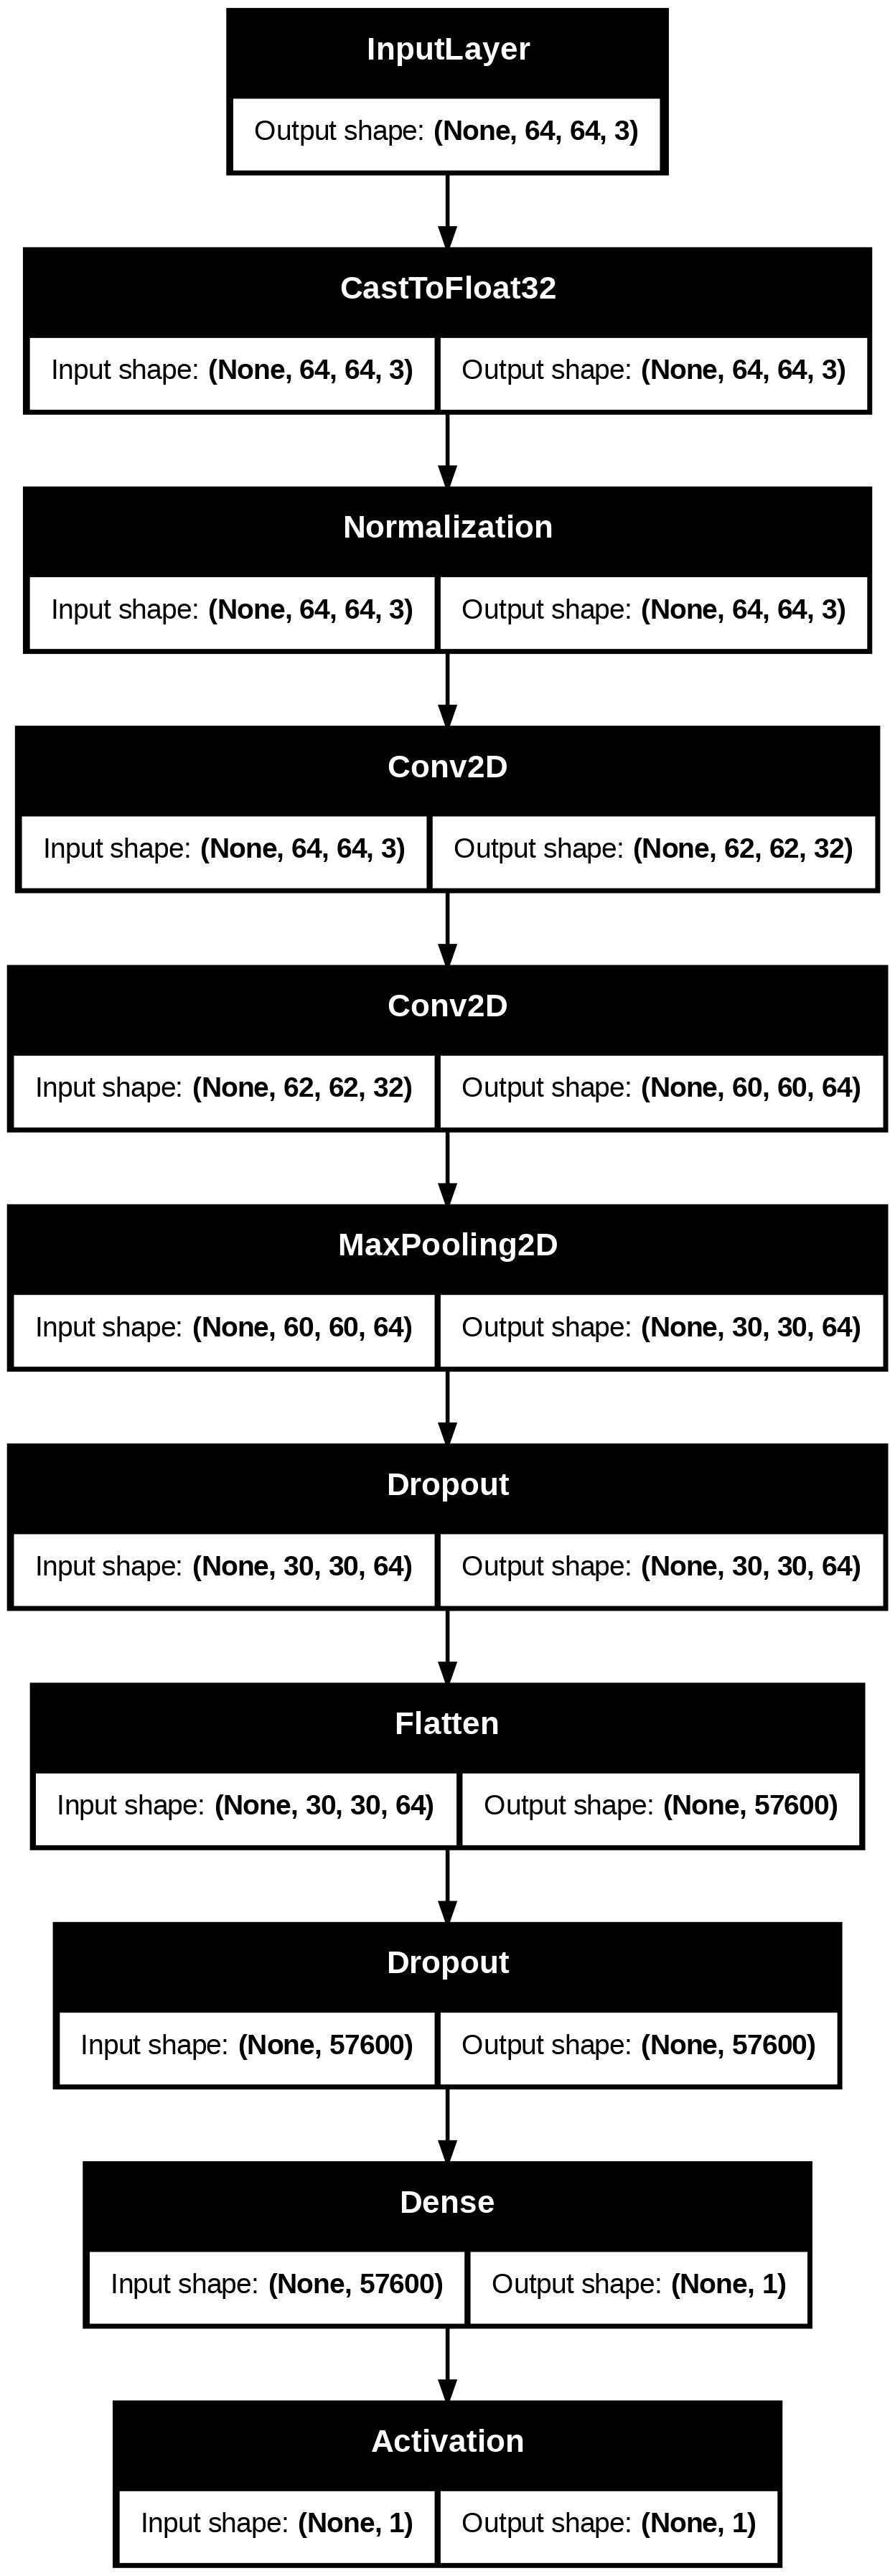

In [25]:
# Save the model
save_model(best_model, '/kaggle/working/best_model.h5')

# Print the model summary
best_model.summary()

# Plot the model architecture
plot_model(best_model, show_shapes=True, to_file="best_model.png")

In [35]:
# Compile the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9447 - loss: 0.1360 - val_accuracy: 0.9091 - val_loss: 0.2492
Epoch 2/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9438 - loss: 0.1416 - val_accuracy: 0.9082 - val_loss: 0.2612
Epoch 3/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9455 - loss: 0.1289 - val_accuracy: 0.9069 - val_loss: 0.2546
Epoch 4/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9509 - loss: 0.1281 - val_accuracy: 0.9043 - val_loss: 0.2519
Epoch 5/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9507 - loss: 0.1293 - val_accuracy: 0.9073 - val_loss: 0.2563
Epoch 6/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9478 - loss: 0.1323 - val_accuracy: 0.9108 - val_loss: 0.2561
Epoch 7/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9478 - loss: 0.1286 - val_accuracy: 0.9126 - val_loss: 0.2479
Epoch 8/80
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9496 - loss: 0.1284 - val_accuracy: 0

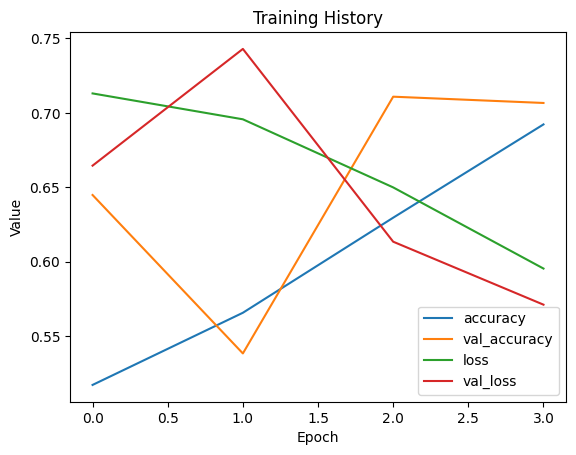

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('Training History')
plt.show()

In [37]:
# Let's inspect first:
print(X_images_test.shape)  # Should be (num_samples, num_frames, 64, 64, 3)

# Get actual numbers
num_samples, num_frames = X_images_test.shape[0], X_images_test.shape[1]

# Reshape for prediction
X_reshaped = X_images_test.reshape(-1, 64, 64, 3)  # (num_samples*num_frames, 64, 64, 3)
y_pred_all = best_model.predict(X_reshaped)

# Now reshape predictions to (num_samples, num_frames)
y_pred_all = y_pred_all.reshape(num_samples, num_frames)

# Average predictions per sample
y_pred_avg = np.mean(y_pred_all, axis=1)

# Get final binary predictions
y_pred_labels = (y_pred_avg > 0.5).astype(int)

(356, 10, 64, 64, 3)
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [38]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(Y_labels_test, y_pred_labels))
print(confusion_matrix(Y_labels_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.59      0.54      0.56       172
           1       0.60      0.65      0.62       184

    accuracy                           0.60       356
   macro avg       0.59      0.59      0.59       356
weighted avg       0.60      0.60      0.59       356

[[ 93  79]
 [ 65 119]]


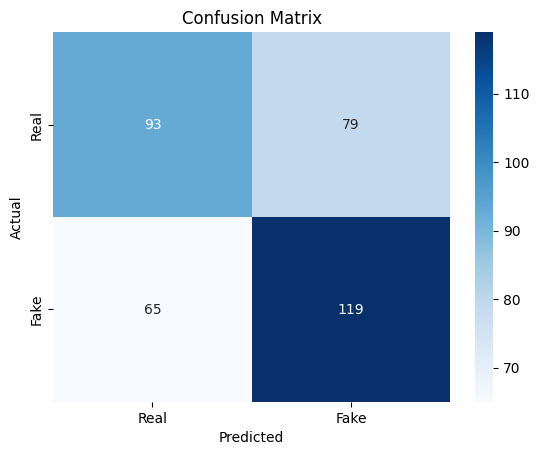

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_labels_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score

# If you have probabilities (from y_pred_avg), use those directly for ROC AUC
roc_auc = roc_auc_score(Y_labels_test, y_pred_avg)  # use the averaged probabilities
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.5380750758341759


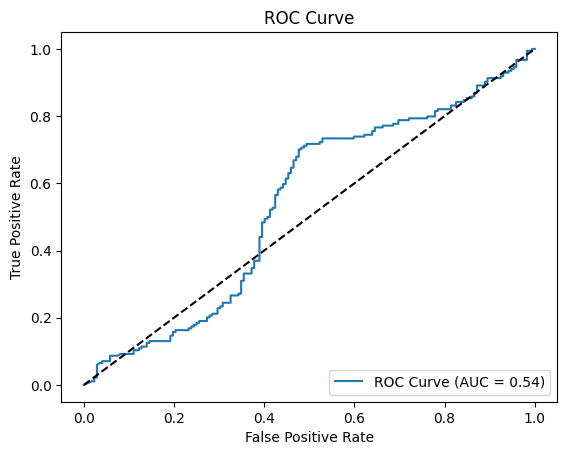

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_labels_test, y_pred_avg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [33]:
import os

# List all zip files in the working directory
for file in os.listdir("/kaggle/working"):
    if file.endswith(".zip"):
        print(file)
        os.remove(file)


In [34]:
import os
import zipfile

# List of full folder paths you want to include in the zip
folders_to_zip = [
    "/kaggle/working/image_classifier/trial_0",
    "/kaggle/working/image_classifier/trial_1"
]

# Output zip path
zip_path = "/kaggle/working/specific_folders.zip"

# Remove old zip if exists
if os.path.exists(zip_path):
    os.remove(zip_path)

# Zip the specified folders
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in folders_to_zip:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                # Keep folder structure inside the zip
                arcname = os.path.relpath(file_path, "/kaggle/working")
                zipf.write(file_path, arcname)

# Create a download link
from IPython.display import FileLink
FileLink(zip_path)

/kaggle/working/specific_folders.zip